In [1]:
! pip install pylibjpeg -q
! pip install python-gdcm -q
! pip install pylibjpeg-libjpeg -q

In [2]:
import numpy as np 
import pandas as pd 
import os

## new library - https://docs.fast.ai/
from fastai.vision.all import *
from fastai.medical.imaging import *
from fastcore.all import *

## image handling and plotting
import pydicom
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from pathlib import Path

In [20]:
#Get working directory and define training data
DATA_DIR = Path("../input/rsna-2022-cervical-spine-fracture-detection/")
train_cases = list((DATA_DIR/"train_images").glob('*'))

In [21]:
from tqdm.notebook import tqdm
print(len(train_cases))

2019


In [22]:
## FastAI get metadata for first image in training images
first_images = []
for case in tqdm(train_cases):
    fns = list(case.glob('*'))
    first_images.append(fns[0]) #there are 2019 images that make up first training case

  0%|          | 0/2019 [00:00<?, ?it/s]

In [23]:
#FastAI converts dicom data to a dataframe
metadata = pd.DataFrame.from_dicoms(first_images)
metadata.head()

,SOPInstanceUID,ContentDate,ContentTime,PatientName,PatientID,SliceThickness,StudyInstanceUID,SeriesInstanceUID,InstanceNumber,MultiImagePositionPatient,...,fname,img_min,img_max,img_mean,img_std,img_pct_window,MultiWindowCenter,WindowCenter1,MultiWindowWidth,WindowWidth1
0,1.2.826.0.1.3680043.17625.1.12,20220727,182645.422631,"(1, 7, 6, 2, 5)",17625,0.625,1.2.826.0.1.3680043.17625,1.2.826.0.1.3680043.17625.1,12,1,...,../input/rsna-2022-cervical-spine-fracture-detection/train_images/1.2.826.0.1.3680043.17625/12.dcm,-2000,3149,490.035950,1353.645241,0.274784,NaN,NaN,NaN,NaN
1,1.2.826.0.1.3680043.3850.1.377,20220727,181857.849868,"(3, 8, 5, 0)",3850,0.500,1.2.826.0.1.3680043.3850,1.2.826.0.1.3680043.3850.1,377,1,...,../input/rsna-2022-cervical-spine-fracture-detection/train_images/1.2.826.0.1.3680043.3850/377.dcm,-2048,1989,-502.369453,885.327879,0.186516,NaN,NaN,NaN,NaN
2,1.2.826.0.1.3680043.2286.1.257,20220727,182445.102098,"(2, 2, 8, 6)",2286,0.625,1.2.826.0.1.3680043.2286,1.2.826.0.1.3680043.2286.1,257,1,...,../input/rsna-2022-cervical-spine-fracture-detection/train_images/1.2.826.0.1.3680043.2286/257.dcm,-2000,2975,314.423233,1248.969559,0.175488,NaN,NaN,NaN,NaN
3,1.2.826.0.1.3680043.14435.1.377,20220727,181025.748551,"(1, 4, 4, 3, 5)",14435,0.600,1.2.826.0.1.3680043.14435,1.2.826.0.1.3680043.14435.1,377,1,...,../input/rsna-2022-cervical-spine-fracture-detection/train_images/1.2.826.0.1.3680043.14435/377.dcm,0,2981,724.398460,466.723094,0.131283,1.0,50.0,1.0,350.0
4,1.2.826.0.1.3680043.3442.1.257,20220727,181040.812134,"(3, 4, 4, 2)",3442,0.625,1.2.826.0.1.3680043.3442,1.2.826.0.1.3680043.3442.1,257,1,...,../input/rsna-2022-cervical-spine-fracture-detection/train_images/1.2.826.0.1.3680043.3442/257.dcm,-2000,2903,336.564178,1289.388440,0.200436,NaN,NaN,NaN,NaN


In [24]:
#Convert to CSV?
metadata.to_csv('/kaggle/working/df.csv',index=False)

(array([ 12.,   1.,   1., 288., 807., 442., 218., 103., 141.,   6.]),
 array([ 350.,  715., 1080., 1445., 1810., 2175., 2540., 2905., 3270.,
        3635., 4000.]),
 <BarContainer object of 10 artists>)

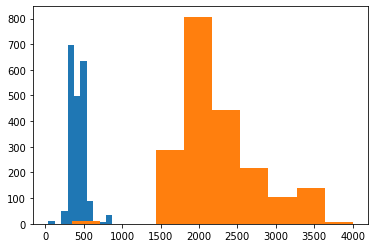

In [25]:
window_center = metadata.WindowCenter.values
window_width = metadata.WindowWidth.values

#blue is center and orange is width
plt.hist(window_center)
plt.hist(window_width)

In [26]:
#default values set to mode of window center and window width
default_window_center = metadata.WindowCenter.mode()
default_window_width = metadata.WindowWidth.mode()

In [27]:
#Adapted from:
#https://pydicom.github.io/pydicom/dev/auto_examples/image_processing/reslice.html
def create_3d(case):
    files = []
    fns = get_dicom_files(case)
    for fn in fns:
        files.append(pydicom.dcmread(fn))
        
    # skip files with no InstanceNumber (eg. Scout)
    slices = []
    skipcount = 0
    for f in files:
        if hasattr(f, 'InstanceNumber'):
            slices.append(f)
        else:
            skipcount = skipcount + 1

    if skipcount > 0:
        print("skipped, no InstanceNumber: {}".format(skipcount))

    # ensure they are in the correct order
    slices = sorted(slices, key=lambda s: s.ImagePositionPatient[2])
    dcm = slices[0]

    # pixel aspects, assuming all slices are the same
    ps = dcm.PixelSpacing
    ss = dcm.SliceThickness
    #ax_aspect = ps[1]/ps[0]
    sag_aspect = ps[1]/ss
    #cor_aspect = ss/ps[0]

    # create 3D array
    img_shape = list(dcm.pixel_array.shape)
    img_shape.append(len(slices))
    img3d = np.zeros(img_shape)
    
    # fill 3D array with the images from the files
    for i, s in enumerate(slices):
        img2d = dcm_apply_windows(s)
        img3d[:, :, i] = img2d
        
    return img3d, sag_aspect, fn.parent.name

def save_sag(img3d, sag_aspect, folder_name, interval=5):
    img_shape = img3d.shape
    for i in range(-4 * interval, 5 * interval, interval):
        arr = img3d[:, img_shape[1]//2 + i, :] * sag_aspect
        #flip and rotate so that C1 is at the top
        arr = np.fliplr(arr)
        arr = np.transpose(arr)
        #array is a tensor from 0 - 1.0, multiply by 256 to get 8 bit image
        arr *= 256
        if not os.path.isdir(f"/kaggle/working/sag/{folder_name}"):
             os.makedirs(f"/kaggle/working/sag/{folder_name}", exist_ok=True)
        im = Image.fromarray(arr)
        #to avoid error from F mode
        if im.mode != 'RGB':
            im = im.convert('RGB')
        save_fn = f'/kaggle/working/sag/{folder_name}/{folder_name}_{i}.jpg'
        im.save(save_fn)

In [28]:
def get_window_from_dicom(dcm, default = (default_window_width,default_window_center)):
    """
    Returns window width and window center values or first example if MultiValue
    Strips comma from value if present (seen in a different dataset)
    If no window width/level is provided or available, returns default.
    """
    width, level = default

    if "WindowWidth" in dcm:
        width = dcm.WindowWidth
        if isinstance(width, pydicom.multival.MultiValue):
            width = float(width[0])
        else:
            width = float(str(width).replace(',', ''))

    if "WindowCenter" in dcm:
        level = dcm.WindowCenter
        if isinstance(level, pydicom.multival.MultiValue):
            level = float(level[0])
        else:
            level = float(str(level).replace(',', ''))
            
    return width, level


def dcm_apply_windows(dcm):
    """
    Applies Intercept/Slope and Window Center/Width
    """
    arr = dcm.pixel_array
    #slope, intercept
    slope = 1
    intercept = 0
    if "RescaleIntercept" in dcm and "RescaleSlope" in dcm:
        intercept = int(dcm.RescaleIntercept)
        slope = int(dcm.RescaleSlope)
        
    arr = arr * slope + intercept
    
    #window
    width,level = get_window_from_dicom(dcm)
    if width is not None and level is not None:
        arr = np.clip(arr, level - width // 2, level + width // 2)
        
     #scale
    arr = (arr - np.min(arr)) / np.max(arr)
        
    return arr

In [29]:
def show_case(folder_name, interval=5):
    plt.figure(figsize=(16, 12))
    count = 1
    #for i in range(-4 * interval, 5 * interval, interval):
    print(5)
    fn = f'/kaggle/working/sag/{folder_name}/{folder_name}_{5}.jpg'
    print("found image")
    img = mpimg.imread(fn)
    print("read image")
    plt.subplot(3,3,count)
    count += 1
    plt.imshow(img, cmap='bone')
    plt.axis("off")
    plt.show()

5
found image
read image


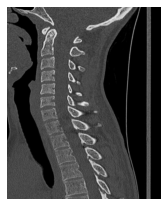

In [30]:
case = DATA_DIR/'train_images/1.2.826.0.1.3680043.2487'

img3d, sag_aspect, folder_name = create_3d(case)
save_sag( img3d, sag_aspect, folder_name)
show_case('1.2.826.0.1.3680043.2487')

In [36]:
def to_sag(case):
    img3d, sag_aspect, folder_name = create_3d(case)
    save_sag( img3d, sag_aspect, folder_name)
    print(str(case) + " complete")

    
cases = (DATA_DIR/"train_images").glob('*')
parallel(to_sag, list(cases))
#for case in tqdm(list(cases)):
#    to_sag(case)


../input/rsna-2022-cervical-spine-fracture-detection/train_images/1.2.826.0.1.3680043.17625 complete
../input/rsna-2022-cervical-spine-fracture-detection/train_images/1.2.826.0.1.3680043.2286 complete
../input/rsna-2022-cervical-spine-fracture-detection/train_images/1.2.826.0.1.3680043.3850 complete
../input/rsna-2022-cervical-spine-fracture-detection/train_images/1.2.826.0.1.3680043.3442 complete
../input/rsna-2022-cervical-spine-fracture-detection/train_images/1.2.826.0.1.3680043.14435 complete
../input/rsna-2022-cervical-spine-fracture-detection/train_images/1.2.826.0.1.3680043.18959 complete
../input/rsna-2022-cervical-spine-fracture-detection/train_images/1.2.826.0.1.3680043.2668 complete
../input/rsna-2022-cervical-spine-fracture-detection/train_images/1.2.826.0.1.3680043.12053 complete
../input/rsna-2022-cervical-spine-fracture-detection/train_images/1.2.826.0.1.3680043.14059 complete
../input/rsna-2022-cervical-spine-fracture-detection/train_images/1.2.826.0.1.3680043.31368 com

Process ForkProcess-8:
Process ForkProcess-9:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/concurrent/futures/process.py", line 233, in _process_worker
    call_item = call_queue.get(block=True)
  File "/opt/conda/lib/python3.7/concurrent/futures/process.py", line 233, in _process_worker
    call_item = call_queue.get(block=True)
  File "/opt/conda/lib/python3.7/multiprocessing/queues.py", line 113, in get
    return _ForkingPickler.loads(res)
  File "/opt/conda/lib/python3.7/multiproces

KeyboardInterrupt: 

In [ ]:
cases = (DATA_DIR/"train_images").glob('*')
print(next(cases))

#instead of showing 9 cases, show one image

In [32]:
to_sag('1.2.826.0.1.3680043.12138')


show_case('1.2.826.0.1.3680043.12138')

NameError: name 'to_sag' is not defined